## This notebook demonstrates running BiPCA on 10X2017PBMC single cell rna seq data

### 1. Load data

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc


from multiprocessing import Pool
import matplotlib.pyplot as plt
from tqdm.contrib.concurrent import thread_map,process_map
from functools import partial
import torch
from threadpoolctl import threadpool_limits


import bipca
from bipca import plotting

from bipca.experiments.datasets.datasets import TenX2017PBMC 

/opt/conda/envs/bipca-experiment/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
data = TenX2017PBMC(base_data_directory = "./") # base_data_directory specifies where the h5ad is stored
adata = data.get_filtered_data()['full'] # note here the data is already filtered for sparsity

Calculating retrieving filtered data...
  Calculating reading filtered data from /data/jyc/software/bipca/python/tutorials/datasets/SingleCellRNASeq/TenX2017PBMC/filtered/full.h5ad...
    Unable to retrieve filtered data from disk.
  Calculating retrieving raw data...
    Calculating reading unfiltered data from /data/jyc/software/bipca/python/tutorials/datasets/SingleCellRNASeq/TenX2017PBMC/unfiltered/full.h5ad...
      Unable to retrieve raw data from disk.
    Calculating processing raw files...
      Calculating extracting pbmc8k.tar.gz...
      Calculating acquiring raw data...
        Calculating downloading https://cf.10xgenomics.com/samples/cell-exp/1.3.0/pbmc8k/pbmc8k_filtered_gene_bc_matrices.tar.gz...
        Calculated downloading https://cf.10xgenomics.com/samples/cell-exp/1.3.0/pbmc8k/pbmc8k_filtered_gene_bc_matrices.tar.gz in 0.73 seconds.
      Calculated acquiring raw data in 0.73 seconds.
      Calculating extracting pbmc8k.tar.gz...
      Calculated extracting pbmc8k

/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   0   0 ... 126   0   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   0   0 ... 126   0   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])


    Calculated filtering AnnData in 2.62 seconds.
  Calculated filtering full in 2.74 seconds.
Calculated retrieving filtered data in 5.75 seconds.


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   0   0 ... 126   0   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])


### 2. run bipca 

In [3]:
n_threads = 36
torch.set_num_threads(n_threads)
with threadpool_limits(limits=n_threads):
    op = bipca.BiPCA(n_components=-1) # get the BiPCA operator, here n_components=-1 is to do full SVD
    Z = op.fit_transform(adata.X.toarray()) # take the count data as input and run bipca
    op.get_plotting_spectrum() # get the fitting parameters
    

Calculating BiPCA fit...
  Calculating variance fit over 5 submatrices...
    Chebyshev approximation of KS reached 1.3928955660799755e-08 with 65 coefficients


/opt/conda/envs/bipca-experiment/lib/python3.10/site-packages/scipy/interpolate/_polyint.py:645: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/opt/conda/envs/bipca-experiment/lib/python3.10/site-packages/scipy/interpolate/_polyint.py:652: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])


    Estimated b=0.9365174591065023, c=0.3155454220367573, KS=0.008274378697235685
    Chebyshev approximation of KS reached 1.1618812685438729e-07 with 65 coefficients
    Estimated b=0.935850547469291, c=0.3253521721384811, KS=0.007733805695480767
    Chebyshev approximation of KS reached 1.3662174903044933e-08 with 65 coefficients
    Estimated b=0.9474462319371909, c=0.3082072014637394, KS=0.007783513122685437
    Chebyshev approximation of KS reached 2.3694010150662595e-11 with 65 coefficients
    Estimated b=0.9401695335185233, c=0.3142427454392816, KS=0.007705990936140328
    Chebyshev approximation of KS reached 5.330555112283557e-08 with 65 coefficients
    Estimated b=0.9437364229537815, c=0.30932634962715344, KS=0.007323952337801809
    Approximating the mean of all submatrices
    Approximation ratio is 5.557258062201217e-10 with 65 coefficients
    b=0.9407994435515061, c=0.31439283161656806
  Calculated variance fit over 5 submatrices in 1354.43 seconds.
  Calculating Sink

In [8]:
Z # BiPCA normalized data matrix

array([[0.50758222, 0.60411906, 0.08249361, ..., 2.23432071, 0.44989701,
        0.        ],
       [0.29076297, 0.36438547, 0.        , ..., 1.02293571, 0.57190712,
        2.62371783],
       [0.43289053, 0.7365852 , 0.15669392, ..., 2.77121283, 0.69522156,
        0.        ],
       ...,
       [0.30484381, 0.37328505, 0.01948817, ..., 1.35149597, 0.51573763,
        2.63674296],
       [0.71081943, 0.65778466, 0.37917215, ..., 2.22520237, 0.62881003,
        0.10429848],
       [0.58601679, 0.79954736, 0.30689903, ..., 2.42655061, 0.56735432,
        0.        ]])

### 3. visualize the MP fit

#### Interpretations
 - Red dash distribution: Theoretical MP distribution
 - Blue histogram: Empirical Spectrum Distribution (EMD) from the biwhitened data
 - KS: Kolmogorov–Smirnov distance between the EMD and the Theoretical MP
 - r: estimated rank
 - b: estimated linear coefficient in the QVF
 - c: estimated quadratic coefficient in the QVF

(<Figure size 3000x1500 with 1 Axes>,
 <Axes: title={'center': 'Biwhitened covariance $\\frac{{1}}{{N}}YY^T$'}, xlabel='Eigenvalue', ylabel='Density'>)

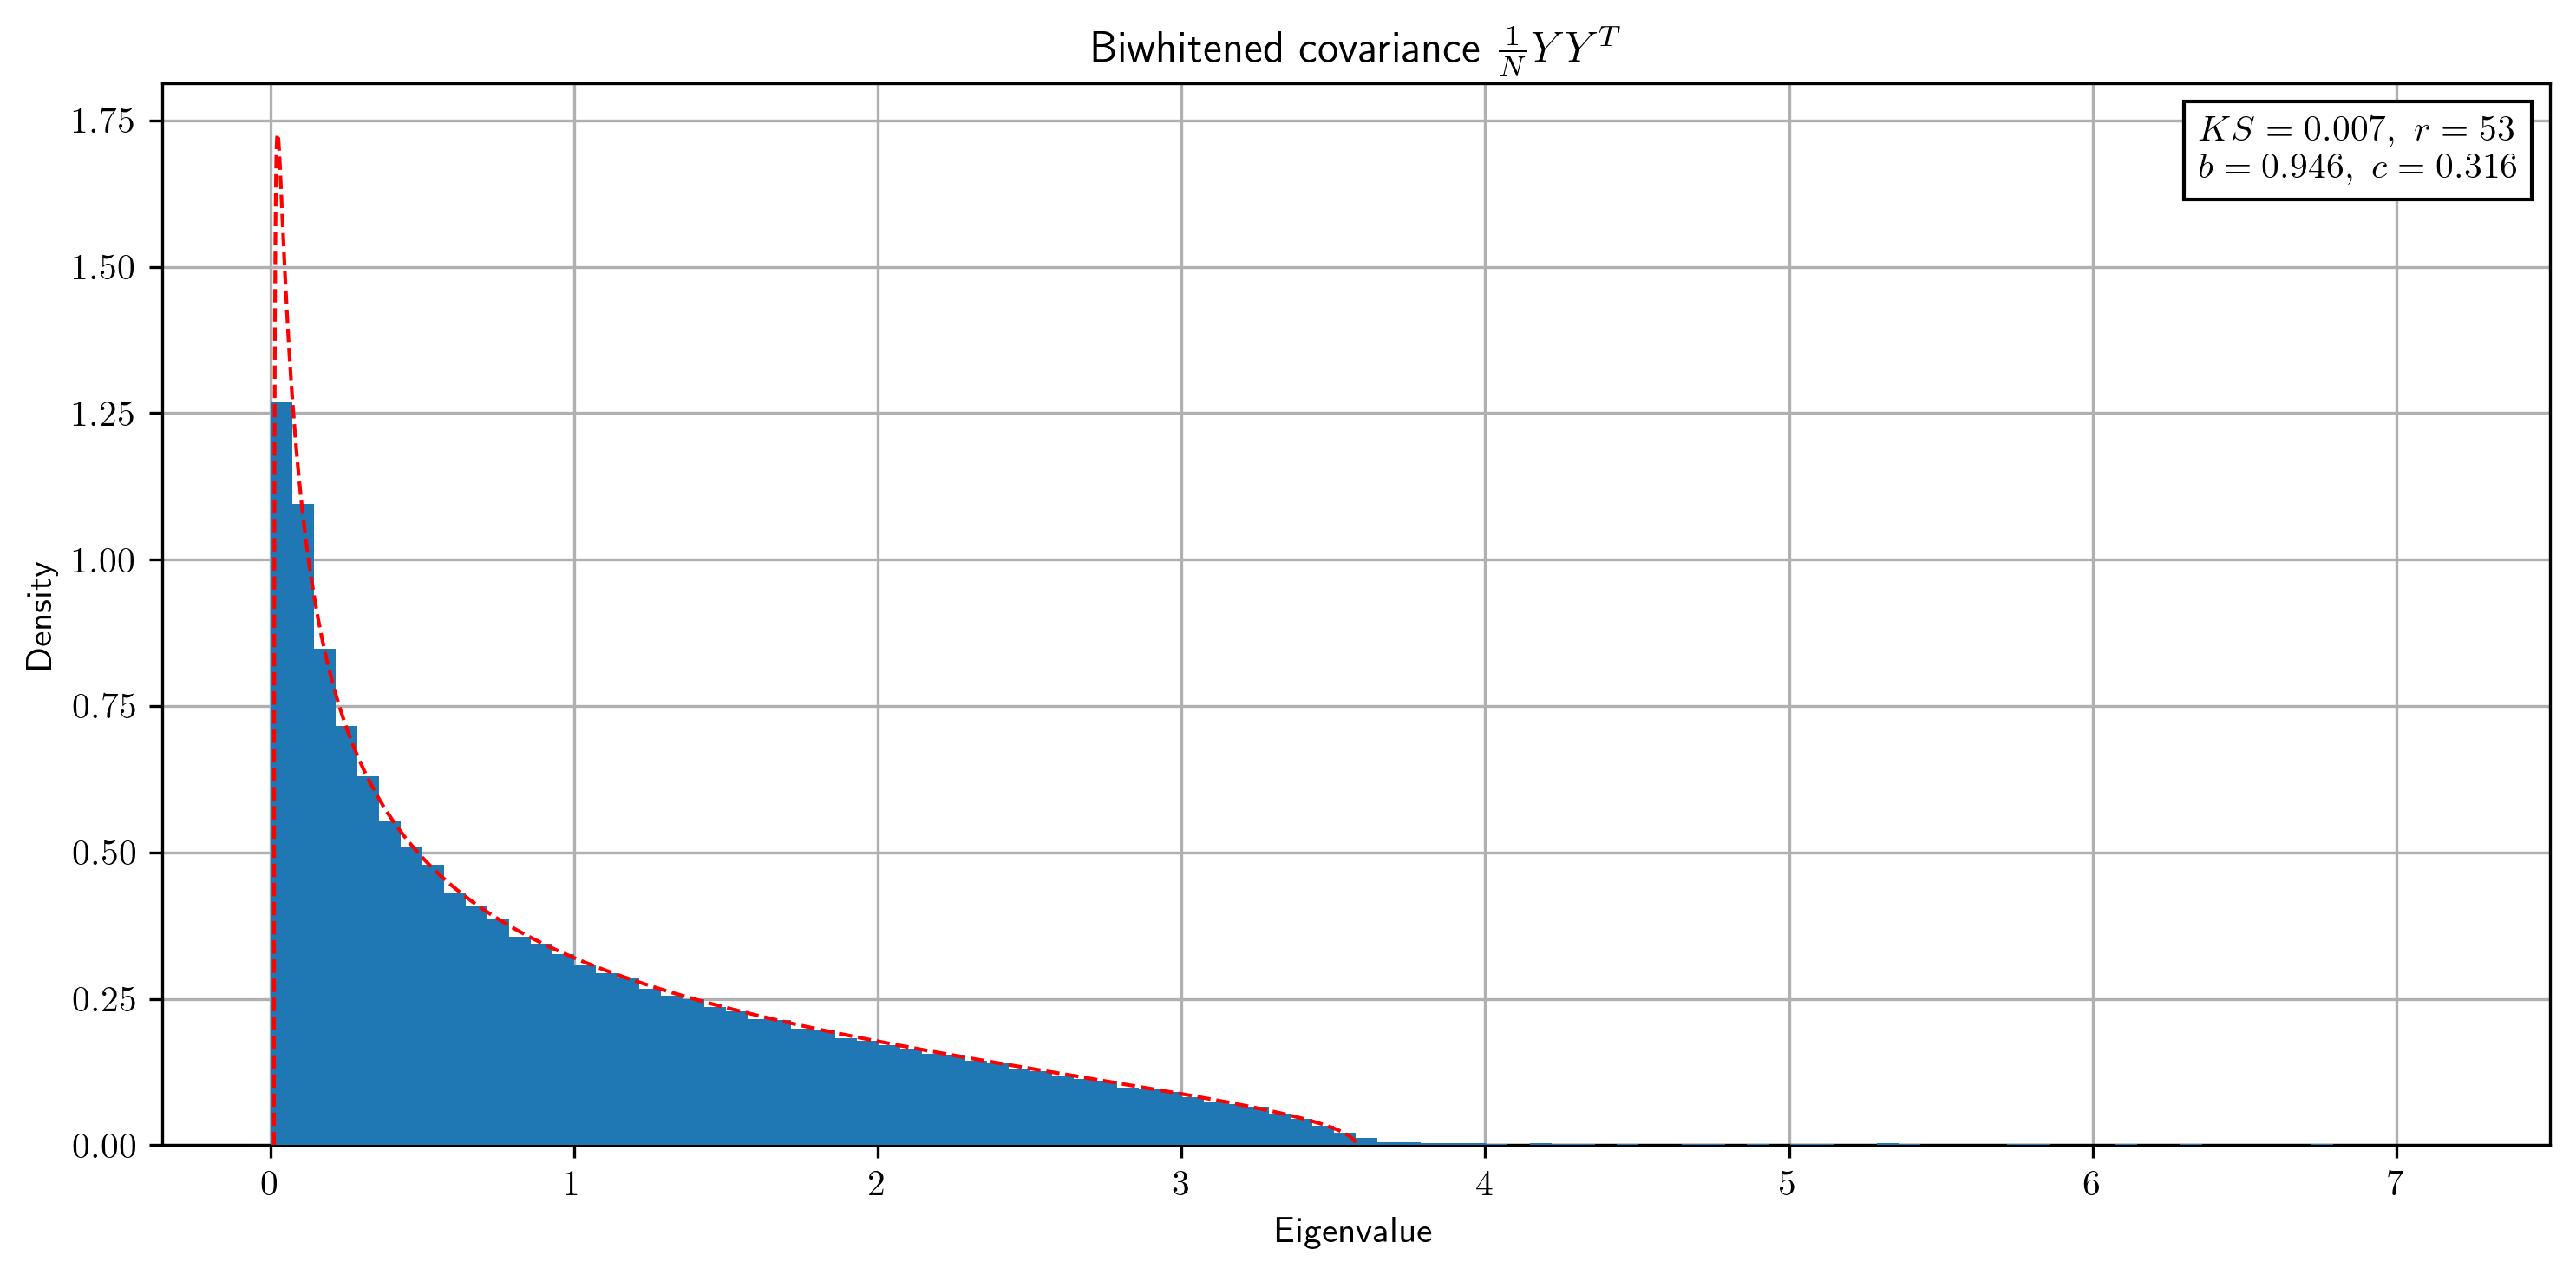

In [4]:
plotting.MP_histograms_from_bipca(op,median=False,bins=100) 

### 4. write the outputs back to the anndata

Instead of using `Z` directly for the downstream analysis, we can also write the outputs from BiPCA to the anndata.

In [5]:
op.write_to_adata(adata) # save the results back to anndata

Calculating Writing bipca to anndata...
  Calculating Shrinking singular values according to frobenius loss...
Calculated Writing bipca to anndata in 2.19 seconds.


AnnData object with n_obs × n_vars = 8380 × 10567
    obs: 'total_UMIs', 'total_MT_UMIs', 'pct_MT_UMIs', 'total_genes'
    var: 'gene_ids', 'total_UMIs', 'total_cells', 'is_MT'
    uns: 'bipca'
    obsm: 'U_biwhite'
    varm: 'V_biwhite'
    layers: 'Y_biwhite', 'Z_biwhite'

Here the BiPCA normalized data `Z` is stored as 'Z_biwhite' in the layers. 

Other useful information in the anndata:

 - KS distance between the EMD and the Theoretical MP: `adata.uns['bipca']['plotting_spectrum']['kst']`
 - estimated rank: `adata.uns['bipca']['rank']`
 - estimated b: `adata.uns['bipca']['plotting_spectrum']['b']`
 - estimated c: `adata.uns['bipca']['plotting_spectrum']['c']`
